# Outlier identification tutorial
This tutorial demonstrates the application of the hierarchical Bayesian model to identify contaminated data points (outliers) in impedance spectra and robustly recover the DRT when outliers are present.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
from copy import deepcopy

if '../bayes-drt' not in sys.path:
    sys.path.append('../bayes-drt')
import drt
from stan_models import save_pickle,load_pickle
import eis_utils as gt

%load_ext autoreload
%autoreload 2

# Load impedance data

For this example, we use experimental data obtained from a protonic ceramic microelectrode.

In [2]:
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

In [76]:
# load experimental data

Zdf = gt.read_eis_zdata(os.path.join(datadir,'experimental','PDAC_COM3_02109_Contact10_2065C_500C.txt'))
# make complex impedance array
Zc = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
# get frequency vector for convenience
freq = Zdf['Freq'].values

In [28]:
cdf = Zdf[~Zdf.index.isin([61,62,63,64])]
Zcc = cdf['Zreal'].values + 1j*cdf['Zimag'].values

<IPython.core.display.Javascript object>


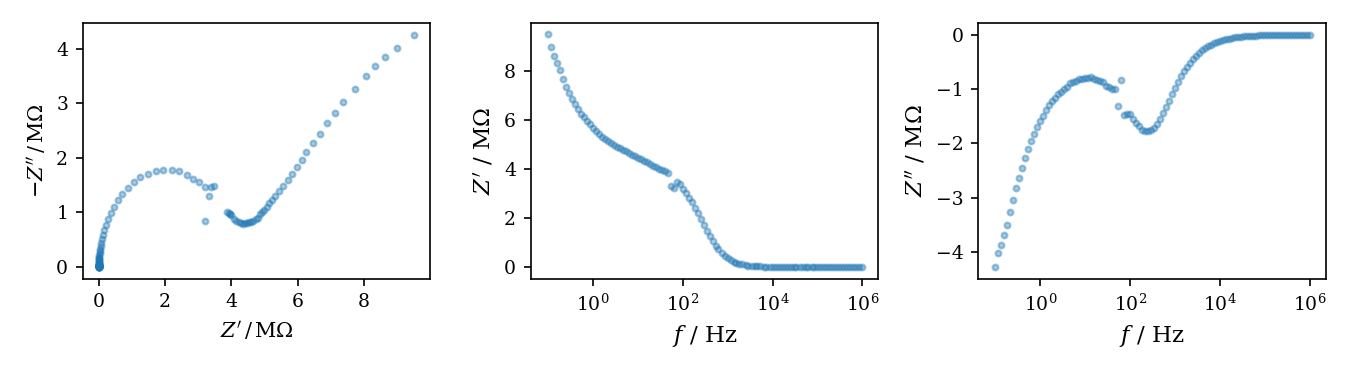

In [79]:
# plot the impedance data
%matplotlib notebook
fig,axes = plt.subplots(1,3,figsize=(9,2.5))
gt.plot_full_eis(Zdf,axes=axes,bode_cols=['Zreal','Zimag'],alpha=0.4)
fig.tight_layout()

The Nyquist and Bode plots reveal several contaminated data points near $f\approx 10^2 \mathrm{Hz}$.
# Hyperparametric ridge fit

In [102]:
# create DRT instance. Extend the frequency range to capture low-frequency semicircle
dr_ridge = drt.DRT(basis_freq=np.logspace(6,-3,91))

# run hyperparametric ridge fit using the recommended hyperparameter values
start = time.time()
dr_ridge.ridge_fit(freq,Zc,beta=2.5,lambda_0=1e-2)
elapsed = time.time() - start
print('Hyperparametric ridge fit time (including matrix construction): {:.3f} s'.format(elapsed))

# re-run with precalculated matrices
start = time.time()
dr_ridge.ridge_fit(freq,Zc,beta=2.5,lambda_0=1e-2)
elapsed = time.time() - start
print('Hyperparametric ridge fit time (without matrix construction): {:.3f} s'.format(elapsed))

../bayes-drt\drt.py:1079: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))
../bayes-drt\drt.py:1192: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  if part=='real':


Hyperparametric ridge fit time (including matrix construction): 47.396 s
Hyperparametric ridge fit time (without matrix construction): 0.086 s


../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Because the basis time constants are not simply the inverted measurement frequencies, *and* the inverted measurement frequencies are not a subset of the basis time constants, the $\mathbf{A}$ matrices are not Toeplitz matrices, and the matrix calculation takes significantly longer.

In [126]:
def plot_drt_result(dr,Zdf,plot_ci=False):
    fig, axes = plt.subplots(2,2,figsize=(7.5,6))
    freq = Zdf['Freq'].values
    
    # plot noisy data
    gt.plot_full_eis(Zdf,axes=axes.ravel()[:3],alpha=0.4,label='Data',bode_cols=['Zreal','Zimag'],s=20)
    # get fitted impedance from DRT instance
    Z_pred = dr.predict(freq)
    df_pred = gt.construct_eis_df(freq,Z_pred)
    # plot impedance fit
    gt.plot_full_eis(df_pred,axes=axes.ravel()[:3],alpha=0.8,label='DRT fit',bode_cols=['Zreal','Zimag'],
                     c='k',plot_func='plot')

    # get the recovered DRT
    tau_plot = np.logspace(np.log10(np.min(dr.tau)),np.log10(np.max(dr.tau)),200)
    g_pred = dr.drt(tau_plot)
    # scale to Mohms
    g_pred /= 1e6
    # plot the recovered DRT
    if plot_ci:
        # plot mean and 95% credibility interval (CI) if MCMC sampling used
        g_lo = dr.drt(tau_plot,percentile=2.5)/1e6
        g_hi = dr.drt(tau_plot,percentile=97.5)/1e6
        axes[1,1].plot(tau_plot,g_pred,c='k',label='Posterior mean',alpha=0.8)
        axes[1,1].fill_between(tau_plot,g_lo,g_hi,color='k',label='95% CI',alpha=0.15)
    else:
        # otherwise plot point estimate only
        axes[1,1].plot(tau_plot,g_pred,c='k',label='Recovered',alpha=0.8)
        
    # mark measurement boundaries in DRT plot
    axes[1,1].axvline(1/(2*np.pi*Zdf['Freq'].min()),ls=':',c='k',lw=1)
    axes[1,1].axvline(1/(2*np.pi*Zdf['Freq'].max()),ls=':',c='k',lw=1)
    
    axes[1,1].set_xscale('log')
    axes[1,1].set_xlabel(r'$\tau$ / s')
    axes[1,1].set_ylabel('$\gamma \ / \ \mathrm{M}\Omega$')

    for ax in axes.ravel():
        ax.legend()

    fig.tight_layout()

<IPython.core.display.Javascript object>


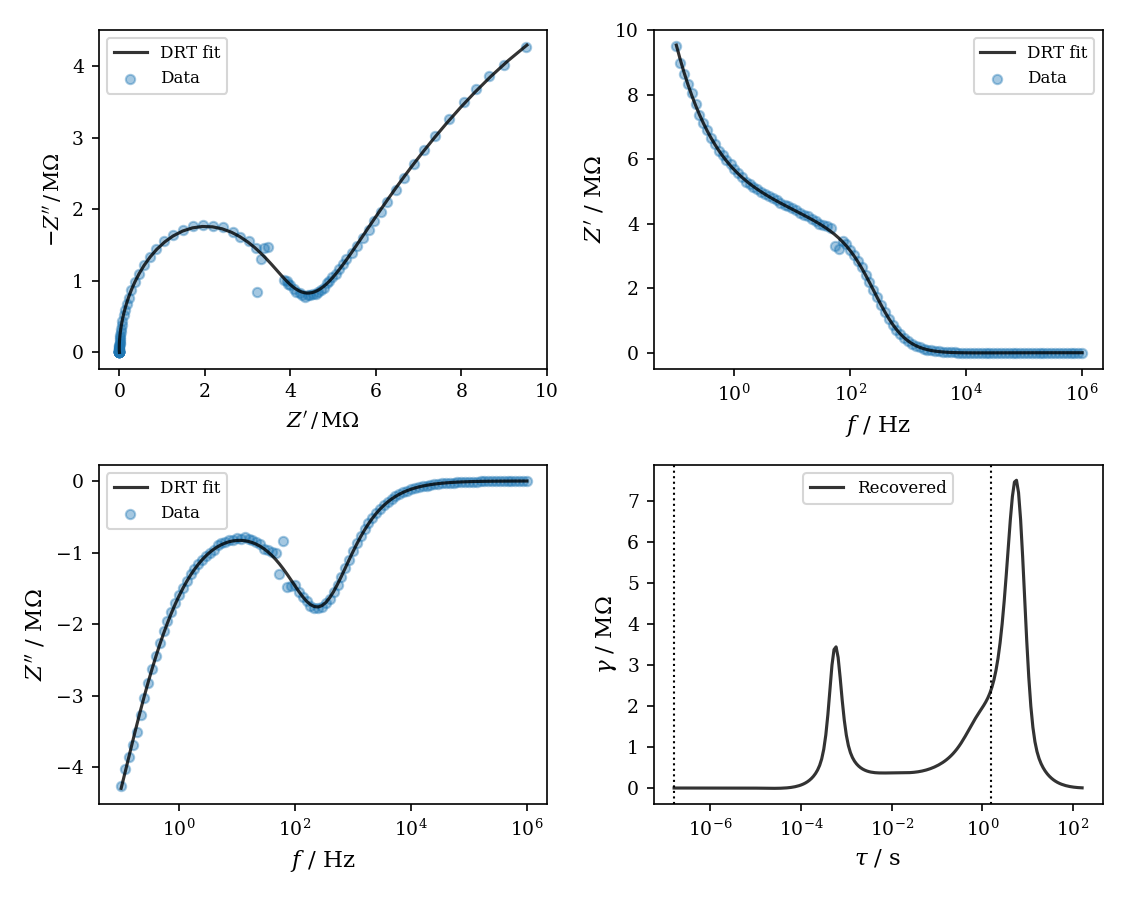

In [110]:
plot_drt_result(dr_ridge,Zdf)

The hyperparametric ridge method is fairly robust to outliers, as illustrated by the good fit obtained above.

## Checking for outliers
Although there is no built-in outlier detection in the `ridge_fit` method, it can be used to quickly check for outliers. The residual plots below clearly indicate the presence of several outliers near $f\approx 10^2 \ \mathrm{Hz}$.

<IPython.core.display.Javascript object>


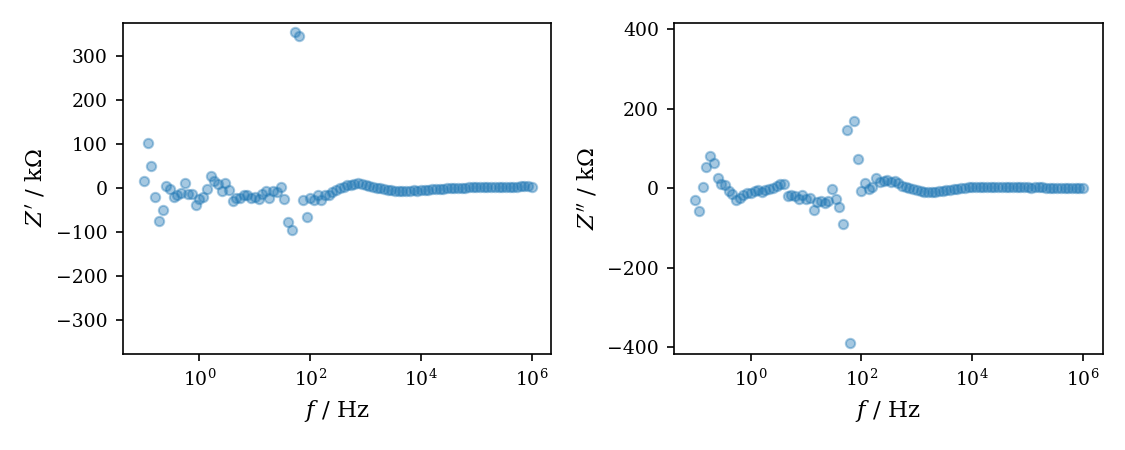

In [123]:
# plot residuals
fig,axes = plt.subplots(1,2,figsize=(7.5,3))

Z_pred = dr_ridge.predict(freq)
df_err = gt.construct_eis_df(freq,Z_pred-Zc)
gt.plot_bode(df_err,axes=axes,cols=['Zreal','Zimag'],alpha=0.4,s=20)

# center y-axis at zero
for ax in axes:
    ymax = np.max(np.abs(ax.get_ylim()))
    ax.set_ylim(-ymax,ymax)

# Hierarchical Bayesian fit via MCMC sampling

## Without outlier detection

For demonstration purposes, we first apply `bayes_fit` without outlier detection enabled.

In [124]:
# sample without outlier detection
# copy dr_ridge - A matrices already calculated
dr_mcmc = deepcopy(dr_ridge)
start = time.time()
dr_mcmc.bayes_fit(freq,Zc,init_from_ridge=False,outliers=False)
elapsed = time.time() - start
print('MCMC sampling time (without outlier detection): {:.2f} s'.format(elapsed))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


MCMC sampling time (without outlier detection): 119.57 s


The warnings about divergences and saturation of maximum tree depth indicate that there *may* have been issues with the sampling. Check your results for "spikiness" or other oddities in the solution if these warnings arise. However, these are warnings, not errors, and are often harmless.

<IPython.core.display.Javascript object>


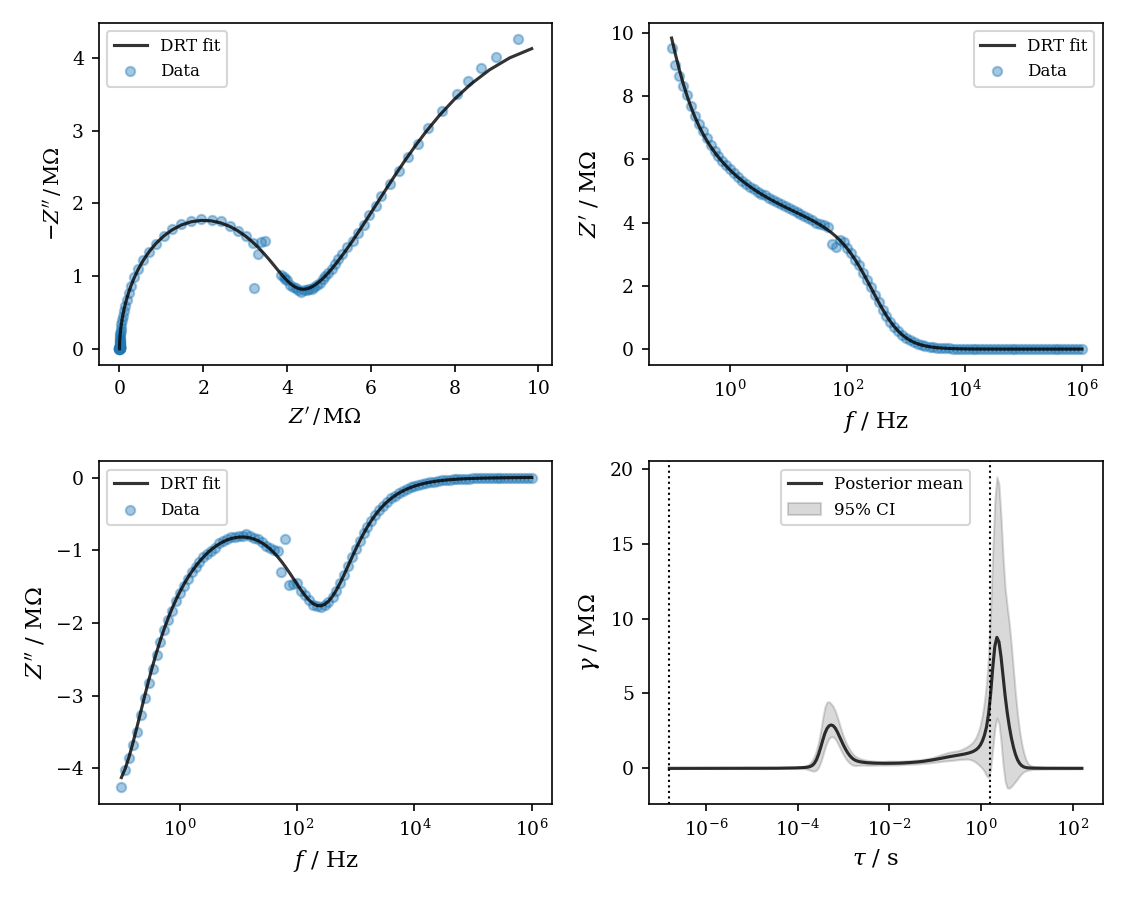

In [127]:
plot_drt_result(dr_mcmc,Zdf,plot_ci=True)

The MCMC solution fits the data well until the frequency drops below $\sim 1 \ \mathrm{HZ}$, at which point the fitted impedance begins to deviate from the measured data significantly. A plot of the residuals and recovered error scale, shown below, reveals why: the large residuals due to the outliers force an anomalously large error scale which extends to low frequencies. This large error scale then makes it appear more probable that the last several data points are significantly perturbed from the true impedance than that the true DRT is large in magnitude outside the measurement bounds.

In [128]:
def plot_resid(dr,Zdf):
    fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)
    freq = Zdf['Freq'].values
    Zc = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
    
    # plot residuals
    Z_pred = dr.predict(freq)
    df_err = gt.construct_eis_df(freq,Z_pred-Zc)
    gt.plot_bode(df_err,axes=axes,cols=['Zreal','Zimag'],alpha=0.4,s=20,label='Residuals',unit_scale='k')

    # get the recovered error scale
    sigma_re, sigma_im = dr.predict_err_scale(freq)
    # plot recovered error scale
    axes[0].fill_between(freq,-3e-3*sigma_re,3e-3*sigma_re,color='k',alpha=0.15,label='Recovered $\pm3\sigma$')
    axes[1].fill_between(freq,-3e-3*sigma_im,3e-3*sigma_im,color='k',alpha=0.15)

    axes[0].legend()
    
    fig.tight_layout()

<IPython.core.display.Javascript object>


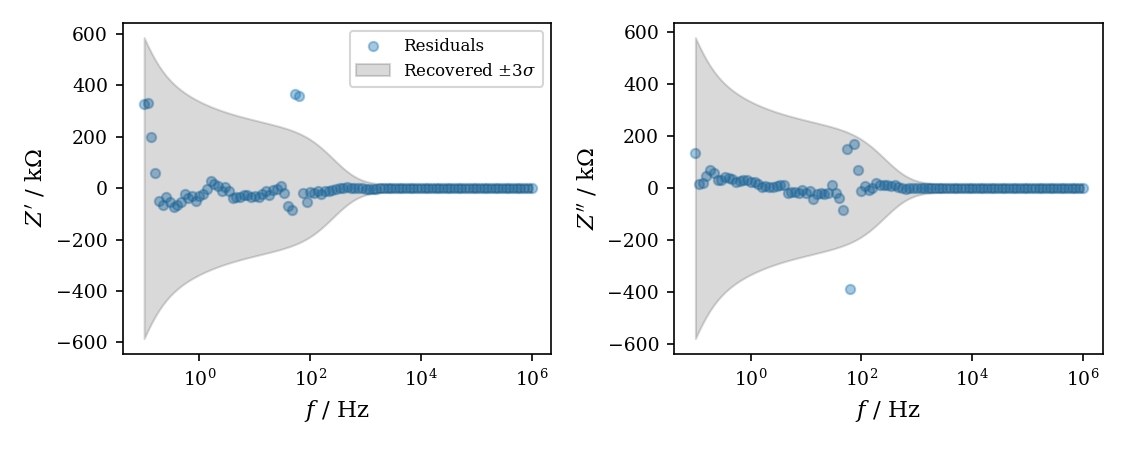

In [129]:
plot_resid(dr_mcmc,Zdf)

## With outlier detection
Now we re-run the fit with outlier detection enabled by passing `outliers=True`.

In [135]:
# sample with outlier detection
dr_mcmc2 = deepcopy(dr_ridge)
start = time.time()
dr_mcmc2.bayes_fit(freq,Zc,init_from_ridge=False,outliers=True)
elapsed = time.time() - start
print('MCMC sampling time (with outlier detection): {:.2f} s'.format(elapsed))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


MCMC sampling time (with outlier detection): 158.92 s


<IPython.core.display.Javascript object>


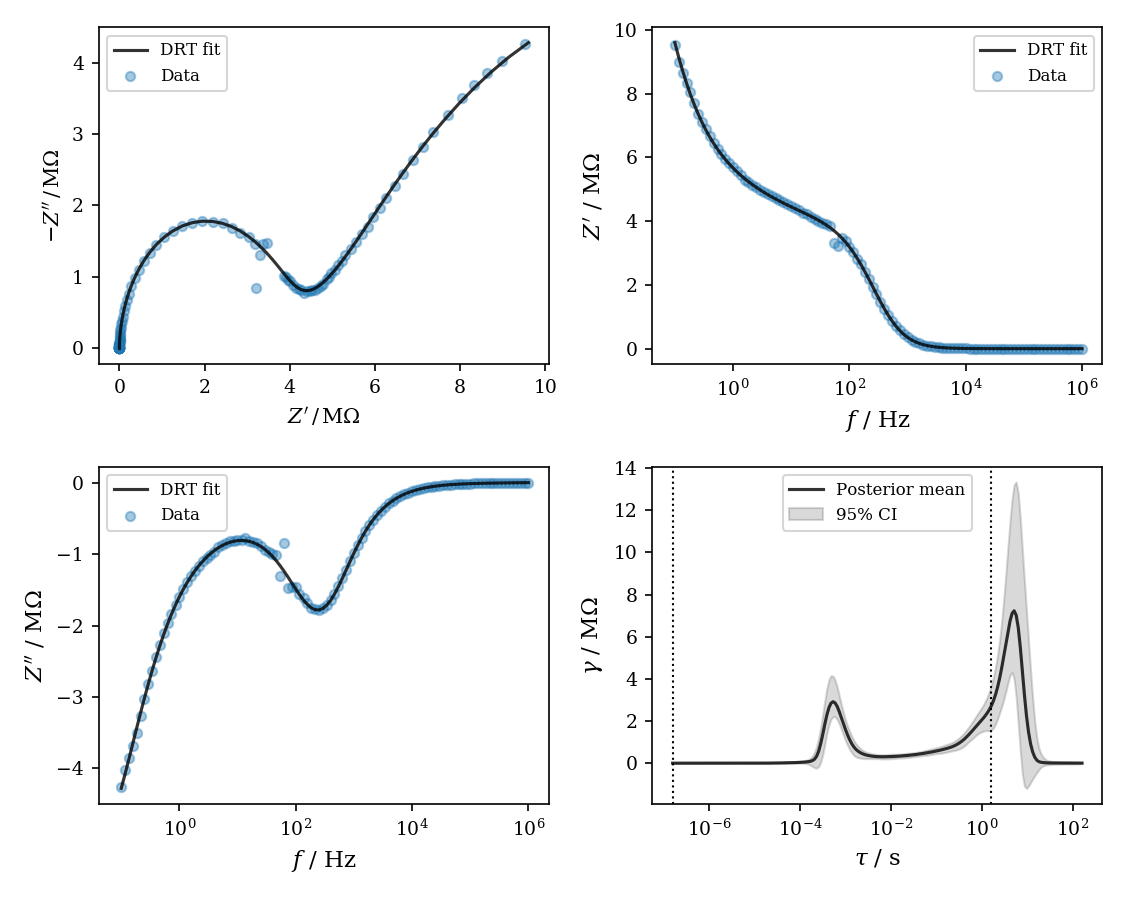

In [137]:
plot_drt_result(dr_mcmc2,Zdf,plot_ci=True)

The fit with outlier detection clearly tracks the data more closely at low frequency. The reason is once again revealed by the residuals and recovered error scale. The independent point-by-point outlier contribution to the error scale allows the model to increase the local error scale as necessary to account for contaminated data points, as indicated by the spikes in the recovered error scale near $f\approx 10^2 \ \mathrm{Hz}$.

<IPython.core.display.Javascript object>


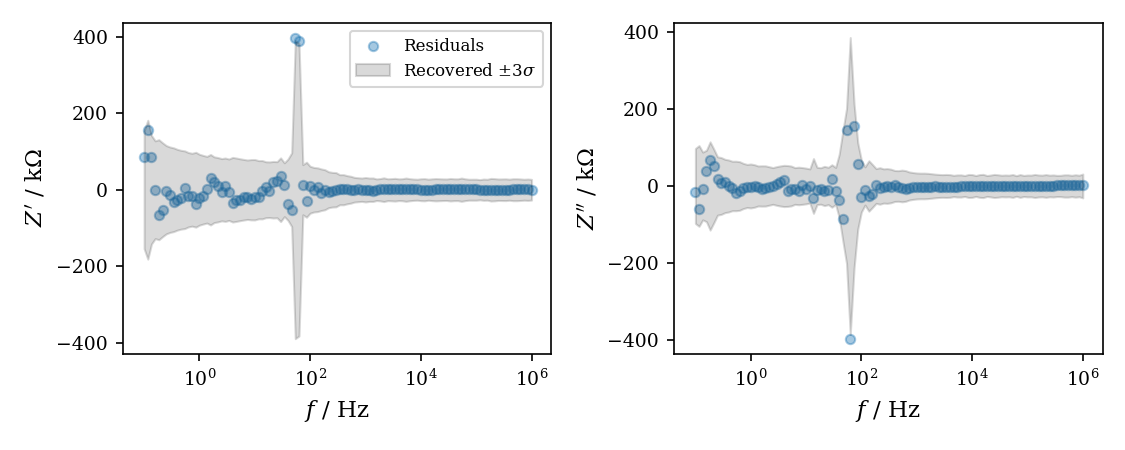

In [136]:
plot_resid(dr_mcmc2,Zdf)

We can check which data points were effectively "flagged" as outliers by examining the outlier error contribution, `sigma_out`. For MCMC sampling, this parameter can be found in the `_sample_result` attribute.

<IPython.core.display.Javascript object>


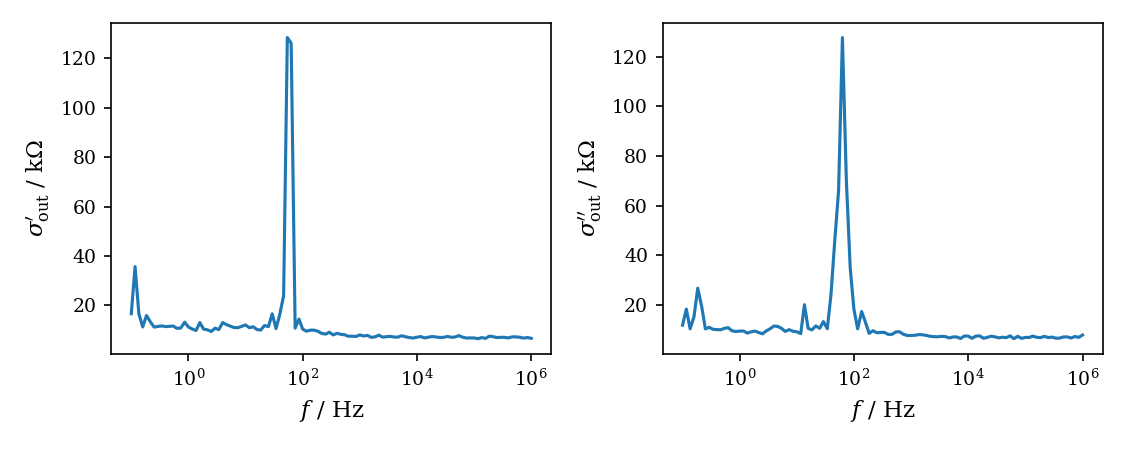

In [141]:
fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)

# get sigma_out
sigma_out = np.mean(dr_mcmc2._sample_result['sigma_out'],axis=0)
sigma_re = sigma_out[:len(dr_mcmc2.f_train)]*dr_mcmc2._Z_scale
sigma_im = sigma_out[len(dr_mcmc2.f_train):]*dr_mcmc2._Z_scale

axes[0].plot(freq,sigma_re/1e3)
axes[1].plot(freq,sigma_im/1e3)

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('$f$ / Hz')
    
axes[0].set_ylabel('$\sigma_{\mathrm{out}}^\prime$ / k$\Omega$')
axes[1].set_ylabel('$\sigma_{\mathrm{out}}^{\prime\prime}$ / k$\Omega$')
    
fig.tight_layout()

The spikes in the `sigma_out` plots clearly flag several points near $f\approx 10^2 \ \mathrm{HZ}$.

One drawback of running MCMC sampling with `outliers=True` is that `sigma_out` tends to take on a baseline non-zero value for non-contaminated points, which may slightly inflate the global error scale, as can be seen in the residual plot (two cells above). However, this effect is usually small enough that it does not cause problems with the resulting fit.

# Hierarchical Bayesian fit via MAP optimization
As for MCMC sampling, we show the MAP results with and without outlier detection.
## Without outlier detection

In [143]:
# run MAP optimization without outlier detection
dr_map = deepcopy(dr_ridge)
start = time.time()
dr_map.map_fit(freq,Zc,init_from_ridge=False,outliers=False)
elapsed = time.time() - start
print('MAP optimization time (without outlier detection): {:.2f} s'.format(elapsed))

MAP optimization time (without outlier detection): 8.66 s


<IPython.core.display.Javascript object>


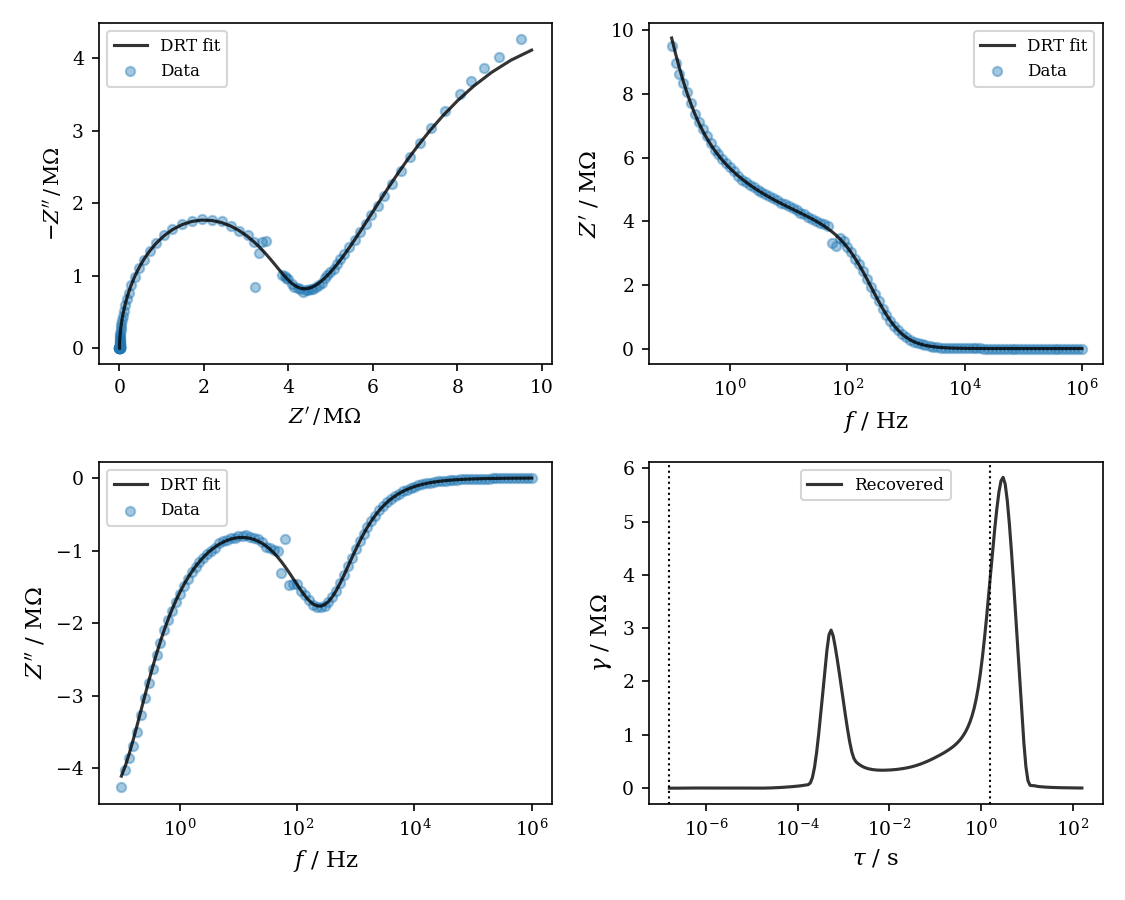

In [144]:
plot_drt_result(dr_map,Zdf)

<IPython.core.display.Javascript object>


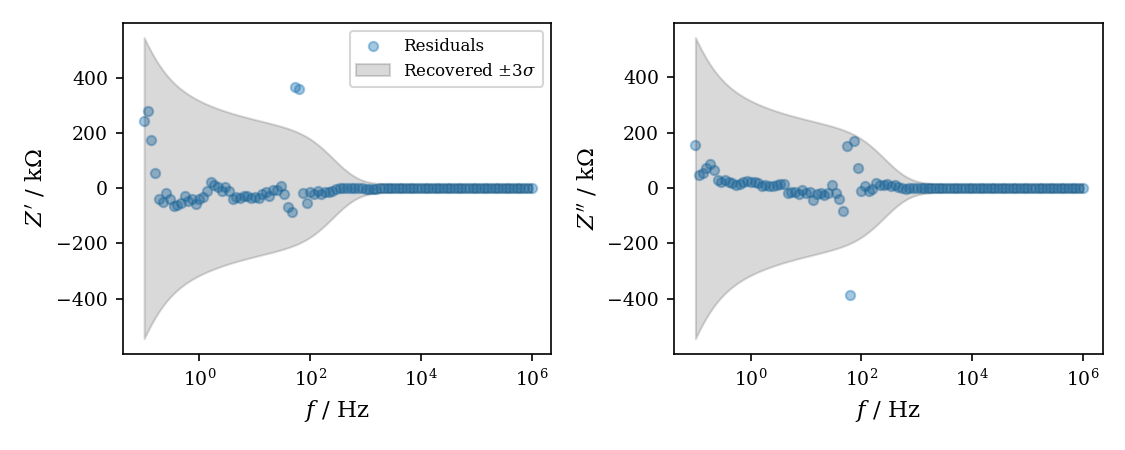

In [145]:
plot_resid(dr_map,Zdf)

The MAP fit without outlier detection behaves very similarly to the MCMC solution.

## With outlier detection

In [146]:
# run MAP optimization with outlier detection
dr_map2 = deepcopy(dr_ridge)
start = time.time()
dr_map2.map_fit(freq,Zc,init_from_ridge=False,outliers=True)
elapsed = time.time() - start
print('MAP optimization time (with outlier detection): {:.2f} s'.format(elapsed))

MAP optimization time (with outlier detection): 18.46 s


<IPython.core.display.Javascript object>


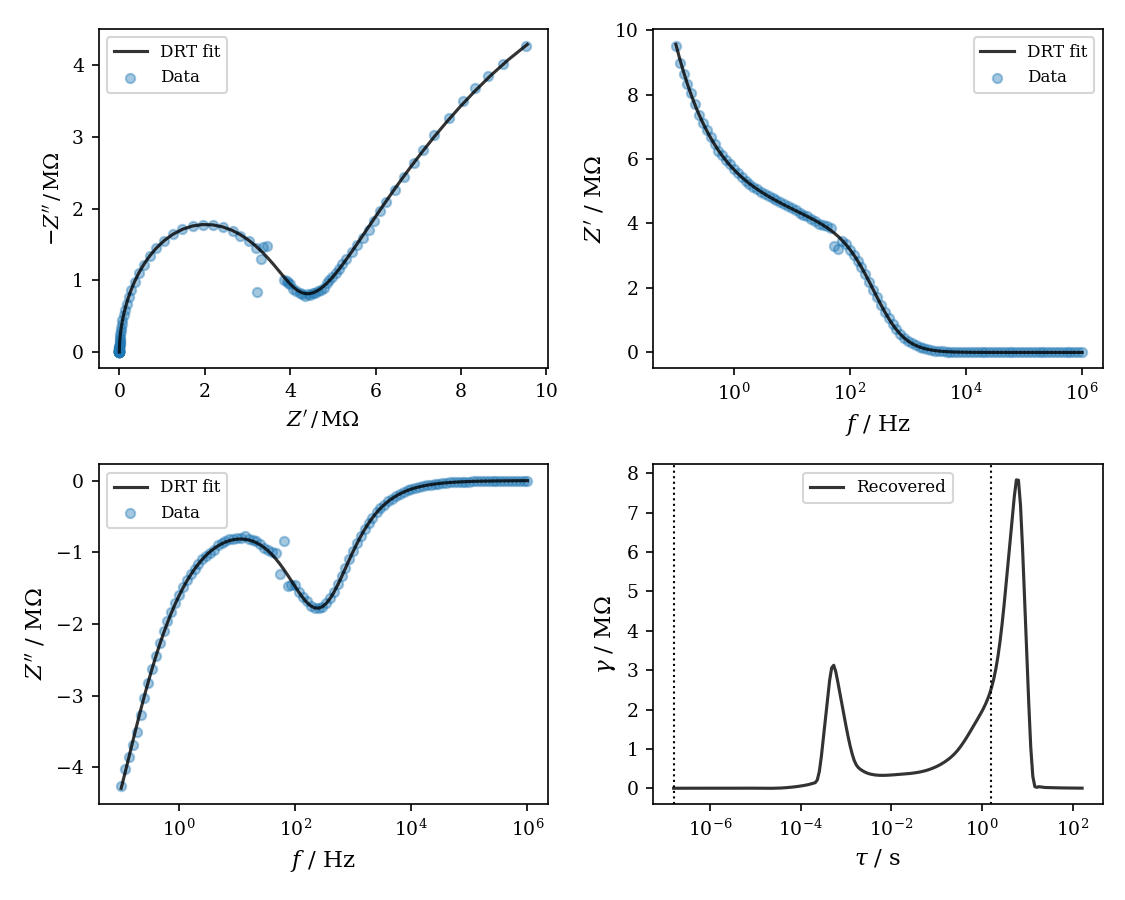

In [147]:
plot_drt_result(dr_map2,Zdf)

<IPython.core.display.Javascript object>


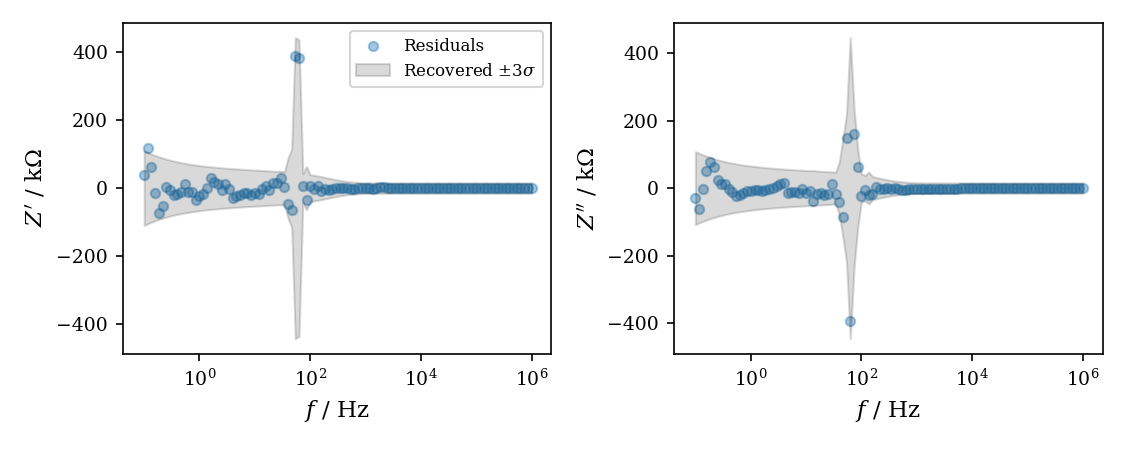

In [148]:
plot_resid(dr_map2,Zdf)

The MAP solution with outlier detection fits the data much better, and the recovered error scale again highlights the presence of contaminated data points. The values of `sigma_out` for the MAP optimization can be found in the `_opt_result` attribute.

<IPython.core.display.Javascript object>


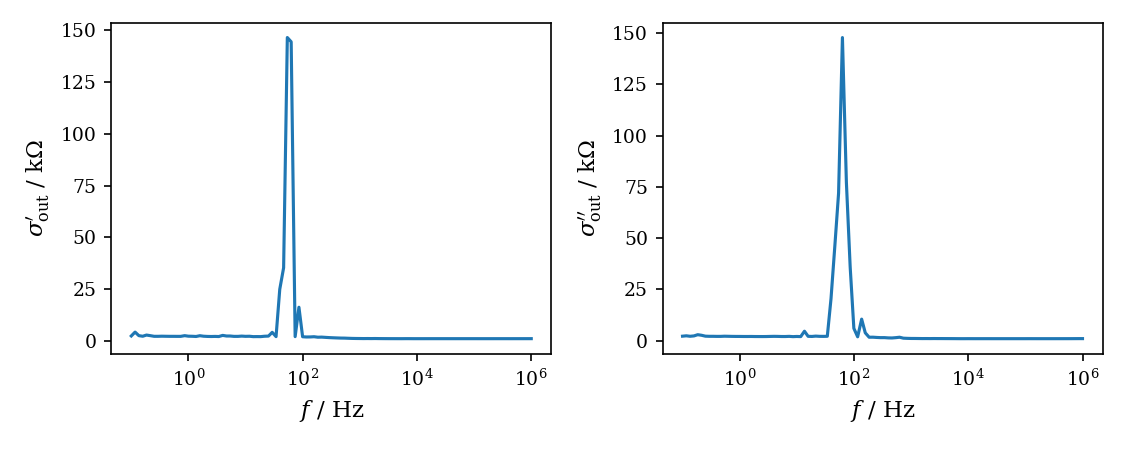

In [149]:
fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)

# get sigma_out
sigma_out = dr_map2._opt_result['sigma_out']
sigma_re = sigma_out[:len(dr_map2.f_train)]*dr_map2._Z_scale
sigma_im = sigma_out[len(dr_map2.f_train):]*dr_map2._Z_scale

axes[0].plot(freq,sigma_re/1e3)
axes[1].plot(freq,sigma_im/1e3)

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('$f$ / Hz')
    
axes[0].set_ylabel('$\sigma_{\mathrm{out}}^\prime$ / k$\Omega$')
axes[1].set_ylabel('$\sigma_{\mathrm{out}}^{\prime\prime}$ / k$\Omega$')
    
fig.tight_layout()

A nice feature of the MAP optimization is that it tends to drive values of `sigma_out` for uncontaminated data points much closer to zero than MCMC sampling, avoiding the slight inflation of the global error scale observed for MCMC sampling.